In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/Colab Notebooks/DIP_Work

/content/drive/My Drive/Colab Notebooks/DIP_Work


In [3]:
! pip install mtcnn;

     |████████████████████████████████| 2.3MB 5.8MB/s 


In [4]:
# from face_recognition.face_recognition import face_locations
from mtcnn import MTCNN
from sklearn.cluster import AgglomerativeClustering, OPTICS, KMeans, MeanShift, DBSCAN, Birch
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2 import threshold
import pickle
from skimage.io import imread_collection
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing, binary_opening, square
from skimage.color import rgb2gray

In [18]:
 #your path 
col = [cv2.imread("Jechiel2.jpeg")]
# col_dir = 'dataset/images/*.jpg'
# mask_dir = 'dataset/masks/*.png'
# #creating a collection with the available images
# col = imread_collection(col_dir)
# true_masks = imread_collection(mask_dir)

In [19]:
def GMM(clip, h, w, n_components):
    grid = np.indices((h, w)).reshape(h,w,-1)
    grid = np.dstack((clip, grid))
    inds = np.arange(h*w);
    vectors = grid[np.unravel_index(inds, (h,w))]
    labels = GaussianMixture(n_components, covariance_type='full').fit_predict(vectors)
    labels = np.reshape(labels,(h,w))
    return labels

def find_main_components(labels, clip, boxed_img, 
                         eccentricity_upper=0.9, 
                         relative_area_lower=0.1
                         ):
    main_components = []
    uniq = np.unique(labels)
    for j in uniq:
      binary = labels == j;
      binary = binary_opening(binary, square(3));
      binary = binary_closing(binary, square(3));
      components = label(binary, connectivity=2);
      # plt.imshow(components)
      # plt.show()
      props = regionprops(components);
      for i in range(0, len(props)):
        if props[i].eccentricity > eccentricity_upper or props[i].area/(h*w) < relative_area_lower:
          continue
        # print("eccentricity: ", props[i].eccentricity)
        # print("relative area: ", props[i].area/(h*w))
        # print("centroid: ", props[i].centroid)
        # plt.imshow(components == i+1, cmap="gray")
        # plt.show()
        main_components.append([props[i].eccentricity, props[i].area/(h*w), props[i].centroid, components == i+1])
    

    plt.figure(1)
    plt.subplot(1,3,1)
    plt.imshow(labels)
    plt.subplot(1,3,2)
    plt.imshow(clip)
    plt.subplot(1,3,3)
    plt.imshow(boxed_img)
    plt.show()

    return main_components

def dice_coef(A, B):
  return 2*np.count_nonzero(A*B)/(np.count_nonzero(A) + np.count_nonzero(B))

  



confidence:  0.8308132290840149


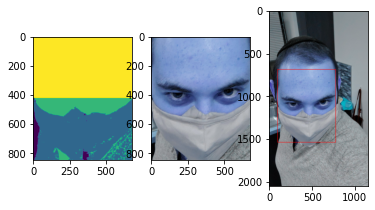

index:  0
dice coefficient:  1.0
MASKS:


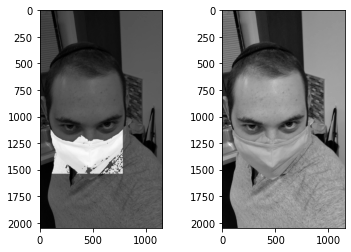

In [20]:
detector = MTCNN()
add2sides = 0
n_components = 4
dice_coefs = []
dbscan = False

for k in range(len(col)):
  try:
    img = col[k]
    # true_mask = true_masks[k];
    true_mask = rgb2gray(img[:,:,:3])
    mask = rgb2gray(img[:,:,:3])
    # true_mask = (true_mask > 0)*1
    # mask = np.zeros(true_mask.shape, dtype=int)
    boxed_img = np.copy(img);
    boxes = detector.detect_faces(img)
    best_components = []
    if boxes:
      for i in range(len(boxes)):
        box = boxes[i]['box']
        conf = boxes[i]['confidence']
        x, y, w, h = box[0] - add2sides, box[1], box[2] + add2sides, box[3]
        if conf < 0.75 and i > 1 or (w < 50 and h < 50):
          continue
        print("confidence: ", conf)
        boxed_img = cv2.rectangle(boxed_img, (x, y), (x + w, y + h), (255, 0, 0), 4)
        # h += np.int(np.power(h,2/3)*2);
        clip = img[y:y+h,x:x+w,:]
        labels = GMM(clip, h, w, n_components)
        main_components = find_main_components(labels, clip, boxed_img)
        best_component = None
        # import pdb; pdb.set_trace()
        while len(main_components) == 1:
          if dbscan:
            break
          if main_components[0][1] > 0.8:
            n_components += 1;
            labels = GMM(clip, h, w, n_components)
            main_components = find_main_components(labels, clip, boxed_img)
          else:
            best_component = main_components[0]
            best_components.append([best_component, box])
            break
        if len(main_components) > 1:
          idx_lowest_centroid = 0;
          val_lowest_centroid = 0;
          for j in range(len(main_components)):
            if main_components[j][2][0] > val_lowest_centroid:
              val_lowest_centroid = main_components[j][2][0];
              idx_lowest_centroid = j;
              best_component = main_components[j];
            else:
              continue

          best_components.append([best_component, box])

    for comp in best_components:
      bound_box = comp[1]
      x, y, w, h = bound_box[0] - add2sides, bound_box[1], bound_box[2] + add2sides, bound_box[3]
      mask[y:y+h,x:x+w] += ((comp[0][-1]) > 0)*1

    DC = dice_coef(mask, true_mask);
    dice_coefs.append(DC)
    print("index: ", k)
    print("dice coefficient: ", DC)
    print("MASKS:")
    plt.figure(2)
    plt.subplot(1,2,1)
    plt.imshow(mask, cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(true_mask, cmap = "gray")
    plt.show()

  except:
    print("EXCEPTION RAISED")
    continue




(array([0.16742081, 0.17647059, 0.18552036, 0.2081448 , 0.27149321,
        0.31221719, 0.3800905 , 0.57466063, 0.78733032, 1.        ]),
 array([0.        , 0.09750708, 0.19501416, 0.29252124, 0.39002832,
        0.4875354 , 0.58504248, 0.68254956, 0.78005663, 0.87756371,
        0.97507079]),
 <a list of 1 Patch objects>)

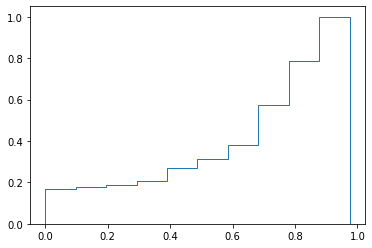

In [ ]:
plt.hist(dice_coefs, density=True, histtype='step', cumulative=True)

In [ ]:
np.average(np.array(dice_coefs))


0.6229957023442315

In [ ]:
print(dice_coefs)

[0.8670648568762728, 0.377711842776927, 0.827190710830691, 0.8082233579983218, 0.8282442748091603, 0.646020101517715, 0.0, 0.8858779091019862, 0.8760761618976173, 0.9333357487047571, 0.8536696550676189, 0.0, 0.5957178841309824, 0.6985641891891892, 0.8581955133453414, 0.85892002734108, 0.6818768056128766, 0.026944585663446874, 0.8712526987161527, 0.6206095791001451, 0.7499819298879653, 0.7158528482514543, 0.7204930741533296, 0.0, 0.0, 0.7088787493455008, 0.6786533385261153, 0.6684996217223627, 0.0, 0.0, 0.0, 0.8952969732174346, 0.7211225320578059, 0.698867617476211, 0.0, 0.4292009087166664, 0.8481249397474212, 0.8932072150029092, 0.5027444196799841, 0.6762384599702944, 0.7391553347628624, 0.9076894495955143, 0.8653192256035641, 0.5854279350938594, 0.7002554511449686, 0.7268524463850007, 0.7626010003847634, 0.8723800999477884, 0.7710923623445826, 0.6325936704256093, 0.7199200366498688, 0.7644868415547467, 0.7082165193012724, 0.8403477300952118, 0.4241748877454033, 0.5120559930008749, 0.9